## M5 Forecast: Keras with Categorical Embeddings V2

In [5]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
from tqdm.notebook import tqdm

In [6]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Load data

In [7]:
path = "../input/csv"

In [11]:
calendar = pd.read_csv(os.path.join(path, "calendar.csv.gz"))
selling_prices = pd.read_csv(os.path.join(path, "sell_prices.csv.gz"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv.gz"))

In [9]:
sales = pd.read_csv(os.path.join(path, "sales_train_validation.csv.gz"))

## Describe and prepare data

We will now go through all data sets and prepare them for modelling.

### Calendar data

For each date (covering both training and test data), we have access to useful calendar information.

In [6]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [7]:
from sklearn.preprocessing import OrdinalEncoder

In [8]:
def prep_calendar(df):
    df = df.drop(["date", "weekday"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    df = df.fillna("missing")
    cols = list(set(df.columns) - {"wm_yr_wk", "d"})
    df[cols] = OrdinalEncoder(dtype="int").fit_transform(df[cols])
    df = reduce_mem_usage(df)
    return df

In [9]:
calendar = prep_calendar(calendar)

Mem. usage decreased to  0.03 Mb (84.7% reduction)


#### Notes for modeling

**Features** deemed to be useful:

- "wday", "year", "month" -> integer coding & embedding
- "event_name_1", "event_type_1" -> integer coding & embedding
- "snap_XX" -> numeric (they are dummies)

**Reshape required**: No

**Merge key(s)**: "d", "wm_yr_wk"

### Selling prices

Contains selling prices for each store_id, item_id_wm_yr_wk combination.


Derive some time related features:


In [10]:
def prep_selling_prices(df):
    gr = df.groupby(["store_id", "item_id"])["sell_price"]
    df["sell_price_rel_diff"] = gr.pct_change()
    df["sell_price_roll_sd7"] = gr.transform(lambda x: x.rolling(7).std())
    df["sell_price_cumrel"] = (gr.shift(0) - gr.cummin()) / (1 + gr.cummax() - gr.cummin())
    df = reduce_mem_usage(df)
    return df

In [11]:
selling_prices = prep_selling_prices(selling_prices)

Mem. usage decreased to 169.63 Mb (53.6% reduction)


In [12]:
def reshape_sales(df, drop_d = None):
    if drop_d is not None:
        df = df.drop(["d_" + str(i + 1) for i in range(drop_d)], axis=1)
    df = df.assign(id=df.id.str.replace("_validation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(1913 + i + 1) for i in range(2 * 28)])
    df = df.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                 var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int16"))
    return df

In [13]:
sales = reshape_sales(sales, 1000)

In [14]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1001,2.0
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1001,0.0
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1001,0.0
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1001,0.0
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1001,1.0
...,...,...,...,...,...,...,...,...
29544805,FOODS_3_823_WI_3,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1969,NaN
29544806,FOODS_3_824_WI_3,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1969,NaN
29544807,FOODS_3_825_WI_3,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1969,NaN
29544808,FOODS_3_826_WI_3,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1969,NaN


In [16]:
def prep_sales(df):
    
    df['lag_t7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(7))
    df['lag_t14'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(14))
    df['lag_t21'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(21))
    df['lag_t28'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
    
    df['rolling_mean_1_7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(1).rolling(7).mean())
    df['rolling_mean_1_28'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(1).rolling(28).mean())
    
    df['rolling_mean_7_7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(7).rolling(7).mean())
    df['rolling_mean_7_28'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(7).rolling(28).mean())

    df['rolling_mean_28_7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df['rolling_mean_28_28'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(28).mean())
    
    df['rolling_std_28_7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df['rolling_std_28_28'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(28).std())
    

    # Remove rows with NAs except for submission rows. rolling_mean_7_28 
    df = df[(df.d >= 1914) | (pd.notna(df.rolling_mean_7_28))]
    df = reduce_mem_usage(df)

    return df

In [17]:
sales = sales.merge(calendar, how="left", on="d")
gc.collect()
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1001,2.0,11339,6,9,2,30,4,4,2,0,0,0
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1001,0.0,11339,6,9,2,30,4,4,2,0,0,0
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1001,0.0,11339,6,9,2,30,4,4,2,0,0,0
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1001,0.0,11339,6,9,2,30,4,4,2,0,0,0
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1001,1.0,11339,6,9,2,30,4,4,2,0,0,0


In [18]:
sales = sales.merge(selling_prices, how="left", on=["wm_yr_wk", "store_id", "item_id"])
sales.drop(["wm_yr_wk"], axis=1, inplace=True)
gc.collect()
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,wday,month,...,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1001,2.0,6,9,...,4,4,2,0,0,0,8.257812,0.0,0.0,0.000000
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1001,0.0,6,9,...,4,4,2,0,0,0,3.970703,0.0,0.0,0.000000
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1001,0.0,6,9,...,4,4,2,0,0,0,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1001,0.0,6,9,...,4,4,2,0,0,0,4.640625,0.0,0.0,0.230713
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1001,1.0,6,9,...,4,4,2,0,0,0,3.080078,0.0,0.0,0.375000


In [19]:
sales = prep_sales(sales)

Mem. usage decreased to 2773.12 Mb (43.3% reduction)


In [20]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,wday,month,...,lag_t21,lag_t28,rolling_mean_1_7,rolling_mean_1_28,rolling_mean_7_7,rolling_mean_7_28,rolling_mean_28_7,rolling_mean_28_28,rolling_std_28_7,rolling_std_28_28
1036660,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1035,1.0,5,10,...,1.0,0.0,0.428467,0.606934,0.142822,0.714355,0.856934,NaN,0.899902,NaN
1036661,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1035,0.0,5,10,...,0.0,0.0,0.000000,0.107117,0.285645,0.142822,0.142822,NaN,0.377930,NaN
1036662,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1035,0.0,5,10,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN
1036663,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1035,5.0,5,10,...,1.0,2.0,2.572266,1.963867,1.571289,2.072266,3.142578,NaN,2.853516,NaN
1036664,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1035,0.0,5,10,...,0.0,2.0,1.000000,0.750000,1.000000,0.678711,0.714355,NaN,0.755859,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29544805,FOODS_3_823_WI_3,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1969,NaN,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29544806,FOODS_3_824_WI_3,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1969,NaN,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29544807,FOODS_3_825_WI_3,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1969,NaN,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29544808,FOODS_3_826_WI_3,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1969,NaN,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
del selling_prices

## Prepare data for Keras interface

### Ordinal encoding of remaining categoricals

In [22]:
cat_id_cols = ["item_id", "dept_id", "store_id", "cat_id", "state_id"]
cat_cols = cat_id_cols + ["wday", "month", "year", "event_name_1", 
                          "event_type_1", "event_name_2", "event_type_2"]

In [23]:
# In loop to minimize memory use
for i, v in tqdm(enumerate(cat_id_cols)):
    sales[v] = OrdinalEncoder(dtype="int").fit_transform(sales[[v]])

sales = reduce_mem_usage(sales)
sales.head()
gc.collect()


Mem. usage decreased to 1848.75 Mb (17.1% reduction)


15

#### Impute numeric columns

In [24]:
num_cols = ["sell_price", "sell_price_rel_diff", "sell_price_roll_sd7", "sell_price_cumrel",
            "lag_t7", 
            "lag_t14", 
            "lag_t21", 
            "lag_t28", 
            "rolling_mean_1_7", 
            "rolling_mean_1_28", 
            "rolling_mean_7_7", 
            "rolling_mean_7_28", 
            "rolling_mean_28_7", 
            "rolling_mean_28_28", 
            "rolling_std_28_7", 
            "rolling_std_28_28"]
bool_cols = ["snap_CA", "snap_TX", "snap_WI"]
dense_cols = num_cols + bool_cols

In [25]:
# Need to do column by column due to memory constraints
for i, v in tqdm(enumerate(num_cols)):
    sales[v] = sales[v].fillna(sales[v].median())
    
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,wday,month,...,lag_t21,lag_t28,rolling_mean_1_7,rolling_mean_1_28,rolling_mean_7_7,rolling_mean_7_28,rolling_mean_28_7,rolling_mean_28_28,rolling_std_28_7,rolling_std_28_28
1036660,HOBBIES_1_001_CA_1,1437,3,1,0,0,1035,1.0,5,10,...,1.0,0.0,0.428467,0.606934,0.142822,0.714355,0.856934,0.464355,0.899902,0.744629
1036661,HOBBIES_1_002_CA_1,1438,3,1,0,0,1035,0.0,5,10,...,0.0,0.0,0.000000,0.107117,0.285645,0.142822,0.142822,0.464355,0.377930,0.744629
1036662,HOBBIES_1_003_CA_1,1439,3,1,0,0,1035,0.0,5,10,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.464355,0.000000,0.744629
1036663,HOBBIES_1_004_CA_1,1440,3,1,0,0,1035,5.0,5,10,...,1.0,2.0,2.572266,1.963867,1.571289,2.072266,3.142578,0.464355,2.853516,0.744629
1036664,HOBBIES_1_005_CA_1,1441,3,1,0,0,1035,0.0,5,10,...,0.0,2.0,1.000000,0.750000,1.000000,0.678711,0.714355,0.464355,0.755859,0.744629


#### Separate submission data and reconstruct id columns

In [34]:
test = sales[sales.d >= 1914]
test = test.assign(id=test.id + "_" + np.where(test.d <= 1941, "validation", "evaluation"),
                   F="F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))
test.head()
gc.collect()

NameError: name 'sales' is not defined

In [27]:
test_long = sales[sales.d >= 1914 - 100]
test_long.head()
gc.collect()

20

#### Make training data

In [28]:
# Input dict for training with a dense array and separate inputs for each embedding input
def make_X(df):
    X = {"dense1": df[dense_cols].to_numpy()}
    for i, v in enumerate(cat_cols):
        X[v] = df[[v]].to_numpy()
    return X

In [29]:
# Submission data
X_test = make_X(test)

In [30]:
# One month of validation data
flag = (sales.d < 1914) & (sales.d >= 1914 - 28)
valid = (make_X(sales[flag]),
         sales["demand"][flag])

In [31]:
# Rest is used for training
flag = sales.d < 1914 #- 7
X_train = make_X(sales[flag])
y_train = sales["demand"][flag]

In [32]:
del sales, flag
gc.collect()

20

In [38]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, concatenate, Flatten
from tensorflow.keras.models import Model

### Architecture with embeddings

In [39]:
def create_model(lr=0.002):
    tf.keras.backend.clear_session()
    gc.collect()

    # Dense input
    dense_input = Input(shape=(len(dense_cols), ), name='dense1')

    # Embedding input
    wday_input = Input(shape=(1,), name='wday')
    month_input = Input(shape=(1,), name='month')
    year_input = Input(shape=(1,), name='year')
    event_name_1_input = Input(shape=(1,), name='event_name_1')
    event_type_1_input = Input(shape=(1,), name='event_type_1')
    event_name_2_input = Input(shape=(1,), name='event_name_2')
    event_type_2_input = Input(shape=(1,), name='event_type_2')
    item_id_input = Input(shape=(1,), name='item_id')
    dept_id_input = Input(shape=(1,), name='dept_id')
    store_id_input = Input(shape=(1,), name='store_id')
    cat_id_input = Input(shape=(1,), name='cat_id')
    state_id_input = Input(shape=(1,), name='state_id')

    wday_emb = Flatten()(Embedding(7, 1)(wday_input))
    month_emb = Flatten()(Embedding(12, 1)(month_input))
    year_emb = Flatten()(Embedding(6, 1)(year_input))
    event_name_1_emb = Flatten()(Embedding(31, 1)(event_name_1_input))
    event_type_1_emb = Flatten()(Embedding(5, 1)(event_type_1_input))
    event_name_2_emb = Flatten()(Embedding(5, 1)(event_name_2_input))
    event_type_2_emb = Flatten()(Embedding(5, 1)(event_type_2_input))

    item_id_emb = Flatten()(Embedding(3049, 3)(item_id_input))
    dept_id_emb = Flatten()(Embedding(7, 1)(dept_id_input))
    store_id_emb = Flatten()(Embedding(10, 1)(store_id_input))
    cat_id_emb = Flatten()(Embedding(3, 1)(cat_id_input))
    state_id_emb = Flatten()(Embedding(3, 1)(state_id_input))

    # Combine dense and embedding parts and add dense layers. Exit on linear scale.
    x = concatenate([dense_input, wday_emb, month_emb, year_emb, 
                     event_name_1_emb, event_type_1_emb, 
                     event_name_2_emb, event_type_2_emb, 
                     item_id_emb, dept_id_emb, store_id_emb,
                     cat_id_emb, state_id_emb])
    
    x = Dense(256, activation="tanh")(x)
    x = Dense(128, activation="tanh")(x)
    x = Dense(64, activation="tanh")(x)
    x = Dense(16, activation="tanh")(x)
    x = Dense(4, activation="tanh")(x)
    
    outputs = Dense(1, activation="linear", name='output')(x)

    inputs = {"dense1": dense_input, "wday": wday_input, "month": month_input, "year": year_input, 
              "event_name_1": event_name_1_input, "event_type_1": event_type_1_input,
              "event_name_2": event_name_2_input, "event_type_2": event_type_2_input,
              "item_id": item_id_input, "dept_id": dept_id_input, "store_id": store_id_input, 
              "cat_id": cat_id_input, "state_id": state_id_input}

    # Connect input and output
    model = Model(inputs, outputs)

    model.compile(loss=keras.losses.mean_squared_error,
                  metrics=["mse"],
                  optimizer=keras.optimizers.Adam(learning_rate=lr))
    return model


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
wday (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
year (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
event_name_1 (InputLayer)       [(None, 1)]          0                                            
______________________________________________________________________________________________

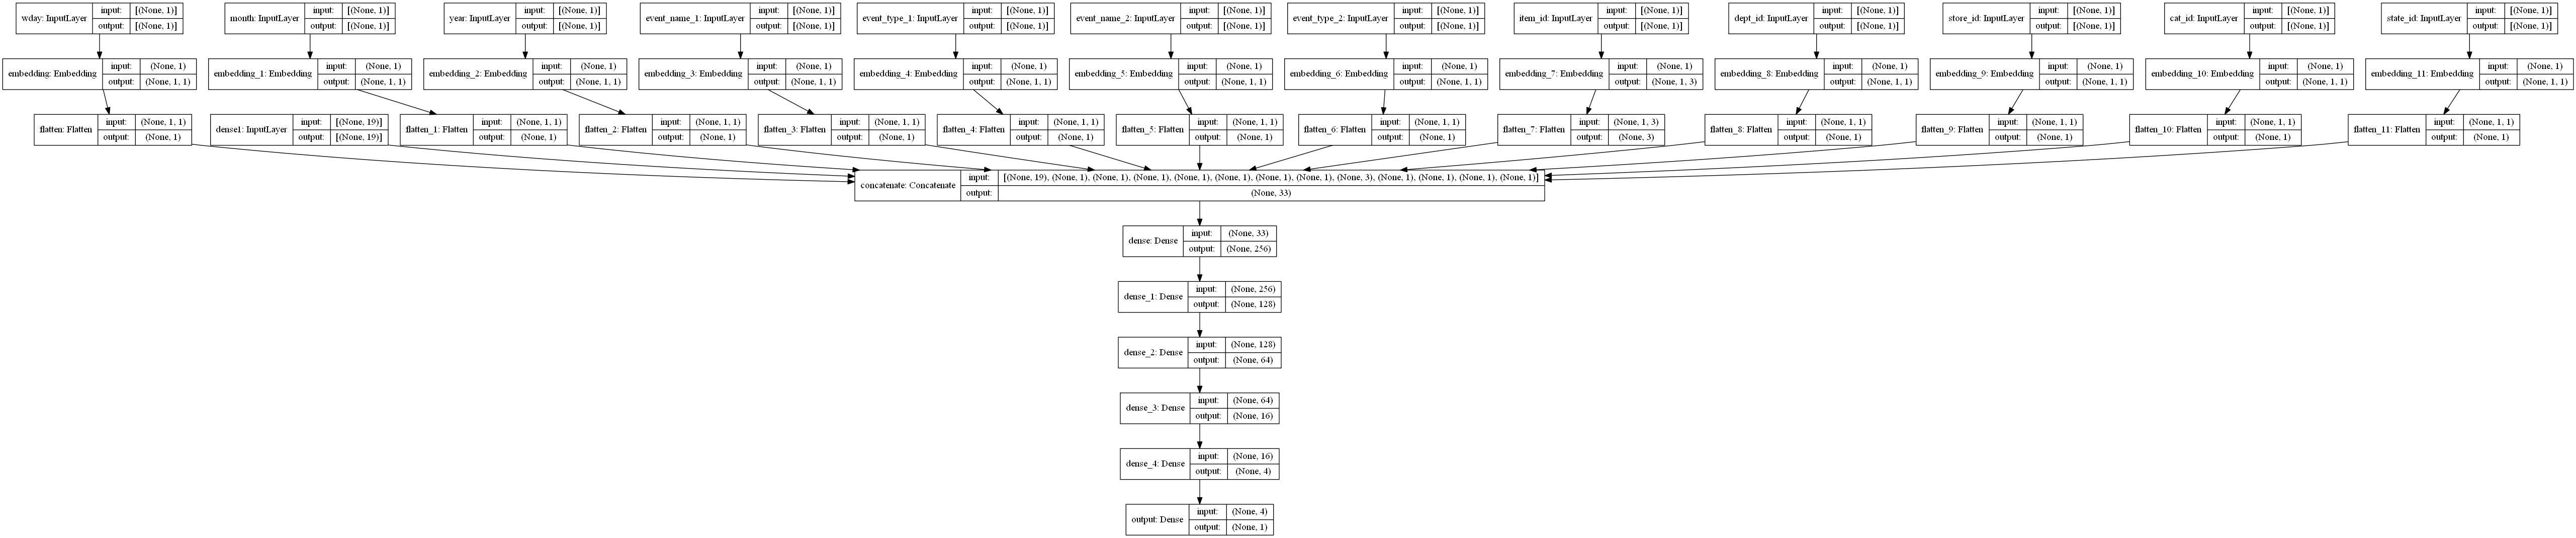

In [40]:
model = create_model(0.0002)
model.summary()
keras.utils.plot_model(model, 'model.png', show_shapes=True)

### Calculate derivatives and fit model

In [41]:
history = model.fit(X_train, 
                    y_train,
                    batch_size=2 ** 14,
                    epochs=100,
                    shuffle=True,
                    validation_data=valid, 
                    verbose=1)

Train on 26800710 samples, validate on 853720 samples
Epoch 1/100
26800710/26800710 [==============================] - 136s 5us/sample - loss: 11.4646 - mean_squared_error: 11.4646 - val_loss: 10.3877 - val_mean_squared_error: 10.3877
Epoch 2/100
26800710/26800710 [==============================] - 135s 5us/sample - loss: 10.2879 - mean_squared_error: 10.2879 - val_loss: 9.3985 - val_mean_squared_error: 9.3985
Epoch 3/100
26800710/26800710 [==============================] - 135s 5us/sample - loss: 9.4971 - mean_squared_error: 9.4971 - val_loss: 8.6614 - val_mean_squared_error: 8.6614
Epoch 4/100
26800710/26800710 [==============================] - 135s 5us/sample - loss: 8.8737 - mean_squared_error: 8.8737 - val_loss: 8.0663 - val_mean_squared_error: 8.0663
Epoch 5/100
26800710/26800710 [==============================] - 136s 5us/sample - loss: 8.3577 - mean_squared_error: 8.3577 - val_loss: 7.5734 - val_mean_squared_error: 7.5734
Epoch 6/100
26800710/26800710 [========================

26800710/26800710 [==============================] - 138s 5us/sample - loss: 3.9294 - mean_squared_error: 3.9294 - val_loss: 3.5857 - val_mean_squared_error: 3.5857
Epoch 93/100
26800710/26800710 [==============================] - 137s 5us/sample - loss: 3.9159 - mean_squared_error: 3.9159 - val_loss: 3.5640 - val_mean_squared_error: 3.5640
Epoch 94/100
26800710/26800710 [==============================] - 138s 5us/sample - loss: 3.9101 - mean_squared_error: 3.9101 - val_loss: 3.5932 - val_mean_squared_error: 3.5932
Epoch 95/100
26800710/26800710 [==============================] - 138s 5us/sample - loss: 3.9065 - mean_squared_error: 3.9065 - val_loss: 3.5803 - val_mean_squared_error: 3.5803
Epoch 96/100
26800710/26800710 [==============================] - 138s 5us/sample - loss: 3.9000 - mean_squared_error: 3.9000 - val_loss: 3.5413 - val_mean_squared_error: 3.5413
Epoch 97/100
26800710/26800710 [==============================] - 138s 5us/sample - loss: 3.8923 - mean_squared_error: 3.89

#### Plot the evaluation metrics over epochs

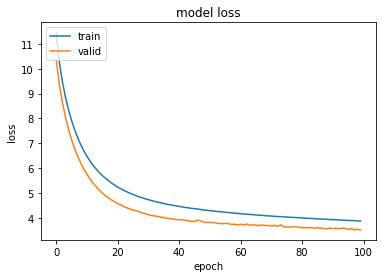

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('plt')

In [43]:
history.history["val_loss"]

[10.387665098437227,
 9.398493802562536,
 8.66139614439187,
 8.066291749036697,
 7.573356637120029,
 7.151967136233099,
 6.786078434033374,
 6.474684964129813,
 6.210352603056402,
 5.959839670672522,
 5.7649033509896865,
 5.565332882689071,
 5.402726406169263,
 5.260481791815092,
 5.11758665723273,
 5.006018167502073,
 4.894276679315635,
 4.8059808600246585,
 4.724344010838572,
 4.646017085501075,
 4.576628250980346,
 4.527640417114459,
 4.453780678501227,
 4.4054466545595785,
 4.356363034175742,
 4.30495376592276,
 4.295029977042332,
 4.232857494785888,
 4.205011347176538,
 4.167588541627584,
 4.130237461171948,
 4.096534202724746,
 4.083229424161115,
 4.059130354733698,
 4.037115027031735,
 4.007389986093347,
 3.986984482597055,
 3.9731219332929637,
 3.9603005690208914,
 3.932379960616113,
 3.92872052753686,
 3.9240342060572226,
 3.9050529158931413,
 3.8919733724972585,
 3.8547214979509468,
 3.8575033285968257,
 3.913323459726675,
 3.880047951741959,
 3.822999874361284,
 3.8190340066

In [44]:
model.save('model_fe.h5')

## Submission

In [45]:
for i in range(1914, 1969 +1):
    print(i)
    if i <= 1941:
        if i>= 1920:
            test_long['lag_t7'] = test_long.groupby(['id'])['demand'].transform(lambda x: x.shift(7))  
            test_long['lag_t14'] = test_long.groupby(['id'])['demand'].transform(lambda x: x.shift(14)) 
            test_long['lag_t21'] = test_long.groupby(['id'])['demand'].transform(lambda x: x.shift(21)) 
            test_long['rolling_mean_7_7'] = test_long.groupby(['id'])['demand'].transform(lambda x: x.shift(7).rolling(7).mean())
            test_long['rolling_mean_7_28'] = test_long.groupby(['id'])['demand'].transform(lambda x: x.shift(7).rolling(28).mean())
        
        test_long['rolling_mean_1_7'] = test_long.groupby(['id'])['demand'].transform(lambda x: x.shift(1).rolling(7).mean())
        test_long['rolling_mean_1_28'] = test_long.groupby(['id'])['demand'].transform(lambda x: x.shift(1).rolling(28).mean())
        forecast = make_X(test_long[test_long.d == i])
        pred = model.predict(forecast, batch_size=2 ** 14)

        test_long.loc[test_long.d == i, "demand"] = pred.clip(0) * 1.01
    else:
        test_long.loc[test_long.d == i, "demand"] = 0

1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969


In [46]:
test = test_long[test_long.d >= 1914]
test = test.assign(id=test.id + "_" + np.where(test.d <= 1941, "validation", "evaluation"),
                   F="F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))
submission = test.pivot(index="id", columns="F", values="demand").reset_index()[sample_submission.columns]
submission = sample_submission[["id"]].merge(submission, how="left", on="id")
submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.862793,0.822754,0.790039,0.889160,0.922852,1.046875,1.194336,0.970703,0.879883,...,1.020508,1.234375,1.258789,0.891602,0.822754,0.803223,0.825195,0.950195,1.129883,1.181641
1,HOBBIES_1_002_CA_1_validation,0.210693,0.216553,0.200317,0.192749,0.209473,0.235596,0.239136,0.241577,0.243042,...,0.270264,0.352051,0.378662,0.250244,0.238647,0.237427,0.235352,0.252197,0.312500,0.324707
2,HOBBIES_1_003_CA_1_validation,0.489258,0.471436,0.485352,0.508301,0.554688,0.679199,0.722656,0.435547,0.405762,...,0.514648,0.752441,0.855469,0.469482,0.443848,0.436279,0.435547,0.487549,0.688477,0.736816
3,HOBBIES_1_004_CA_1_validation,1.663086,1.433594,1.426758,1.345703,1.954102,2.443359,2.761719,2.107422,1.707031,...,2.037109,2.978516,3.167969,1.907227,1.619141,1.525391,1.607422,2.113281,3.080078,2.816406
4,HOBBIES_1_005_CA_1_validation,1.049805,0.923340,0.930664,0.968750,1.106445,1.414062,1.722656,1.172852,1.172852,...,1.250977,1.711914,1.835938,1.100586,1.012695,0.989746,1.026367,1.207031,1.625977,1.729492


In [47]:
submission.to_csv("Keras_with_Categorical_Embeddings_FE.csv", index=False)

In [48]:
test_long.to_csv("Keras_with_Categorical_Embeddings_FE_test_long.csv", index=False)